In [77]:
import os, platform, sys, h5py
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interact, FloatSlider, Checkbox, FloatRangeSlider

if 'Windows' in platform.system():
    sys.path.append(r'C:\Users\slab\Documents\Code')
    sys.path.append(r'D:\BEMPP_shared\Modules')
    import interpolate_slow
else:
    sys.path.append("/Users/gkoolstra/Documents/Code")
    from BEMHelper import interpolate_slow
    
from Common import common, kfit
from TrapAnalysis import trap_analysis
from TrapAnalysis import artificial_anneal as anneal

%matplotlib inline
%config InlineBackend.figure_format='retina'

Directory: 170118_143444_M018V2_resonator_Vsweep_50_electrons
	Out of 196 simulations, 0 did not converge...


/Users/gkoolstra/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:68: RuntimeWarning: divide by zero encountered in log10


Directory: 170118_140803_M018V2_resonator_Vsweep_75_electrons
	Out of 196 simulations, 0 did not converge...
Directory: 170118_132418_M018V2_resonator_Vsweep_100_electrons
	Out of 196 simulations, 0 did not converge...
Directory: 170124_101926_M018V2_resonator_Vsweep_125_electrons
	Out of 196 simulations, 0 did not converge...
Directory: 170124_112414_M018V2_resonator_Vsweep_130_electrons
	Out of 196 simulations, 0 did not converge...
Directory: 170124_120809_M018V2_resonator_Vsweep_135_electrons
	Out of 196 simulations, 0 did not converge...
Directory: 170124_131448_M018V2_resonator_Vsweep_140_electrons
	Out of 196 simulations, 0 did not converge...
Directory: 170124_152925_M018V2_resonator_Vsweep_145_electrons
	Out of 196 simulations, 0 did not converge...
Directory: 170124_163706_M018V2_resonator_Vsweep_150_electrons
	Out of 196 simulations, 0 did not converge...
Directory: 170124_175432_M018V2_resonator_Vsweep_155_electrons
	Out of 196 simulations, 0 did not converge...
Directory: 

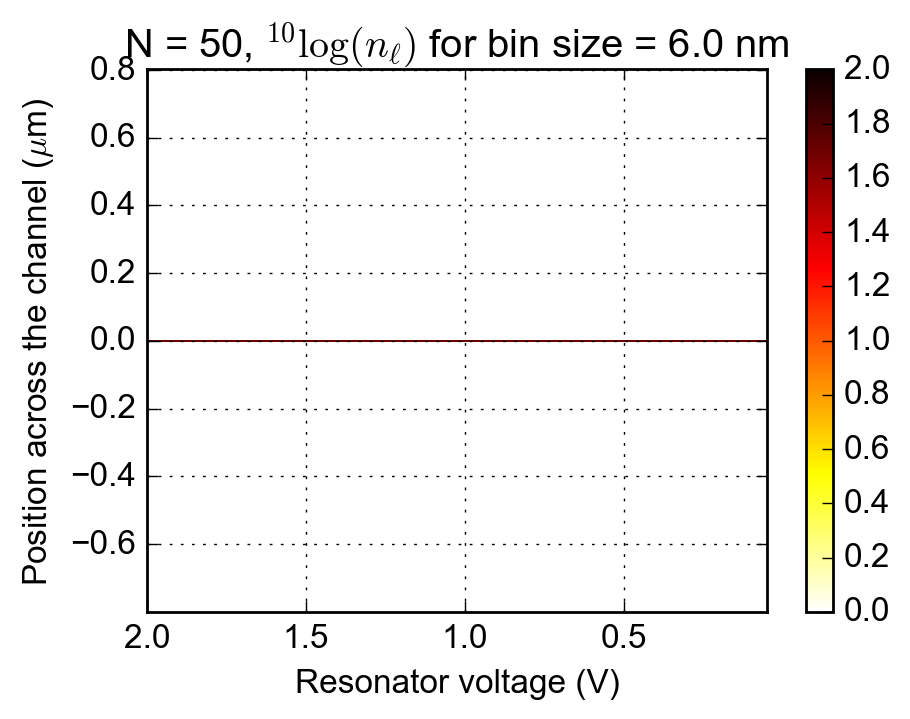

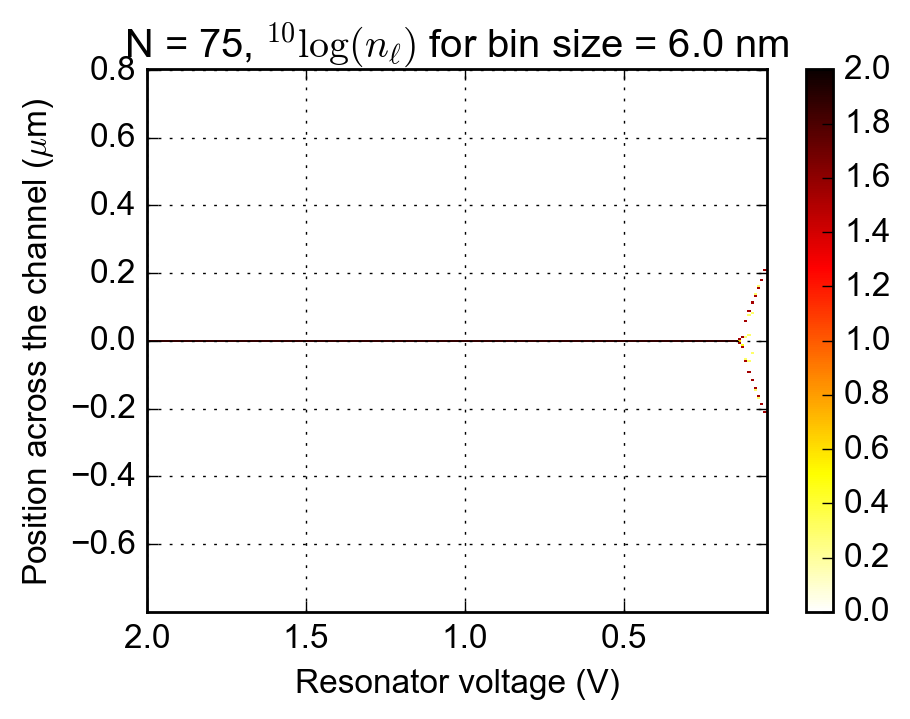

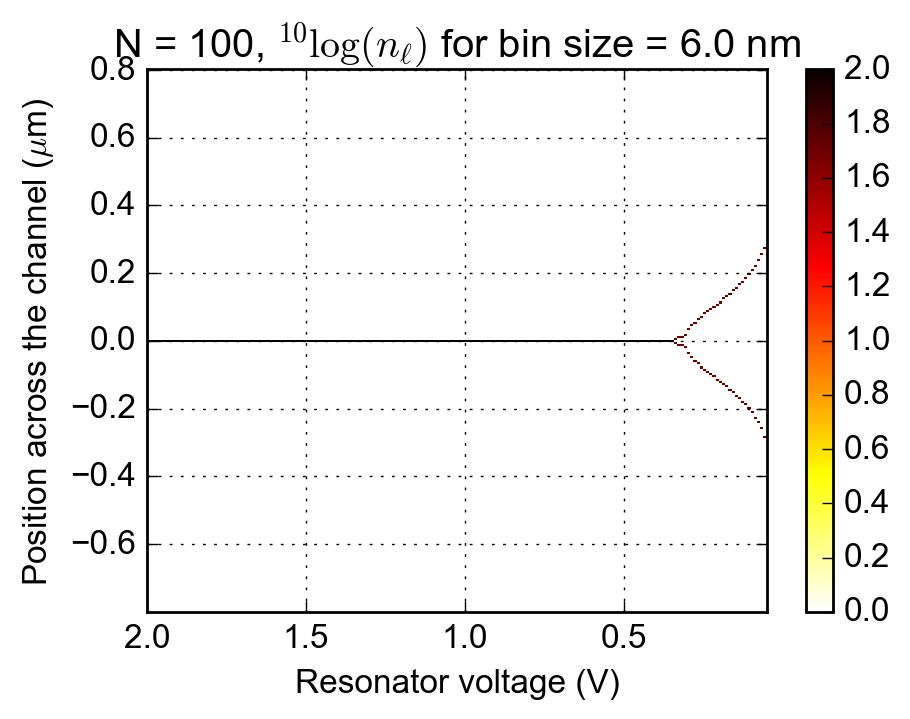

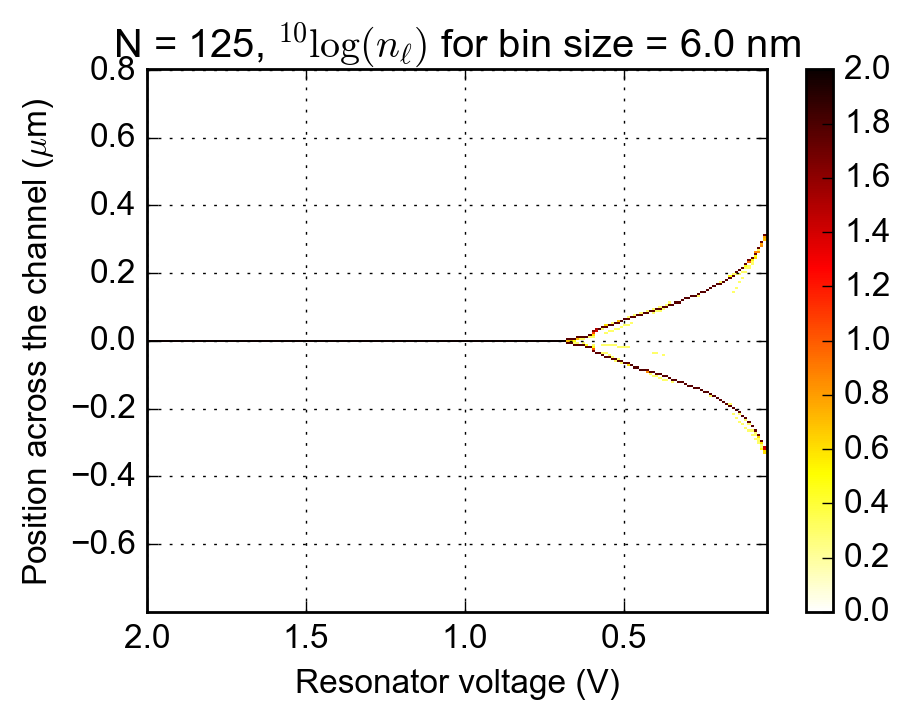

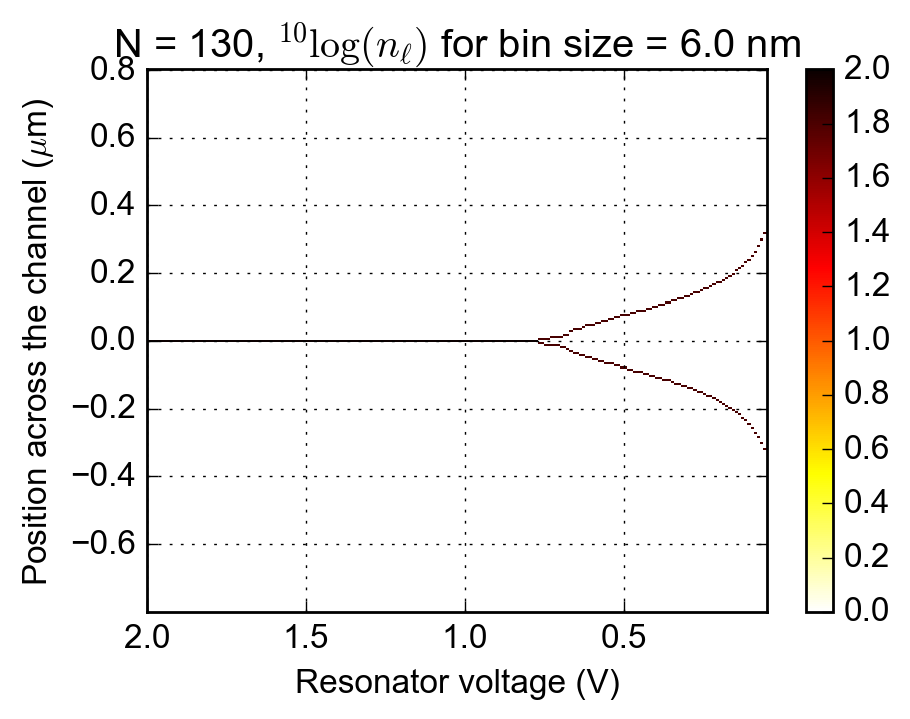

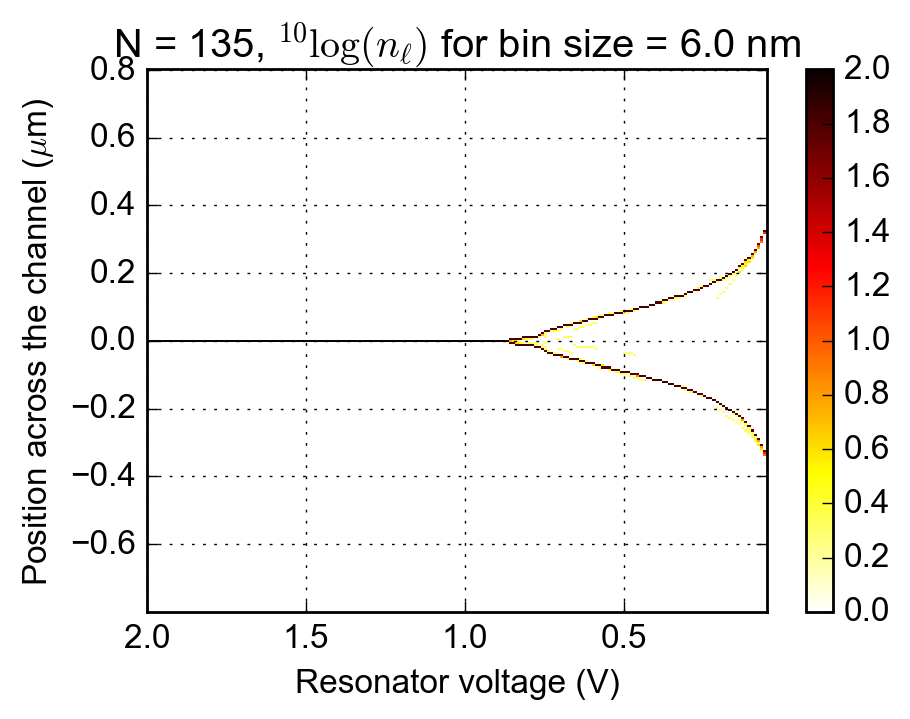

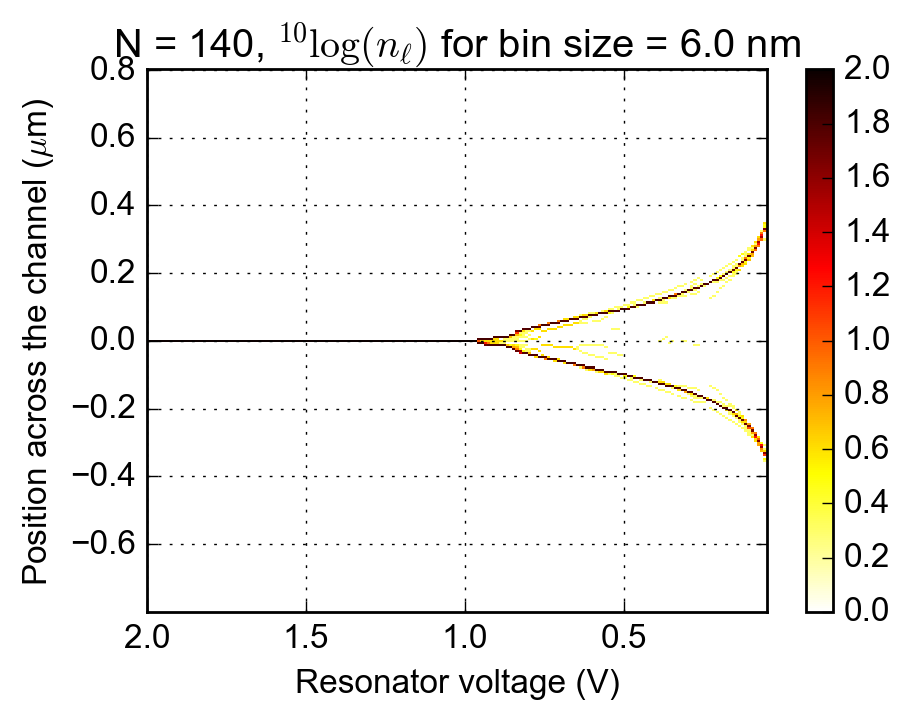

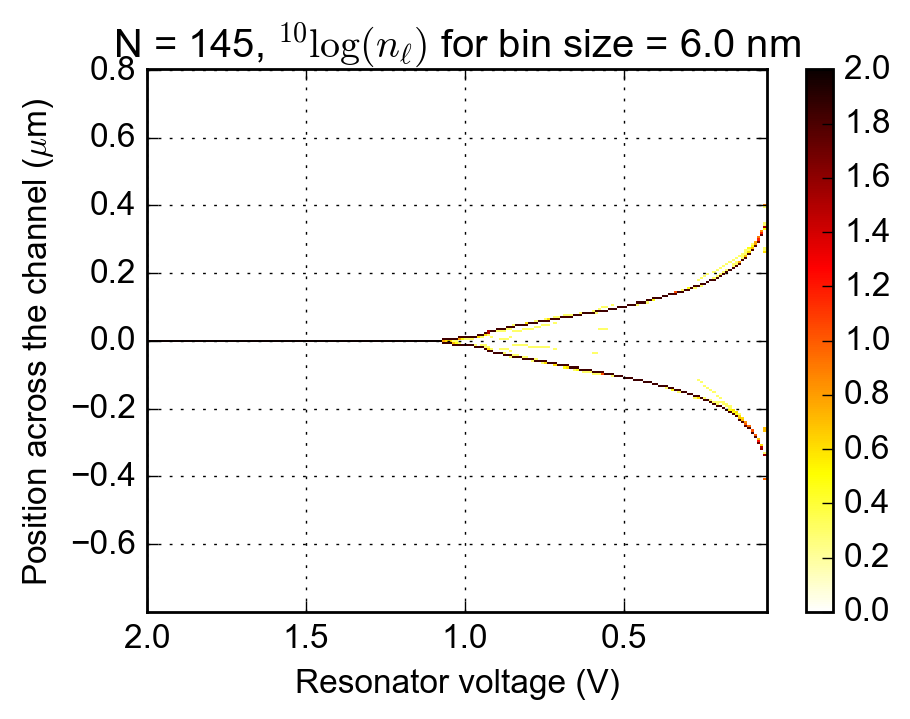

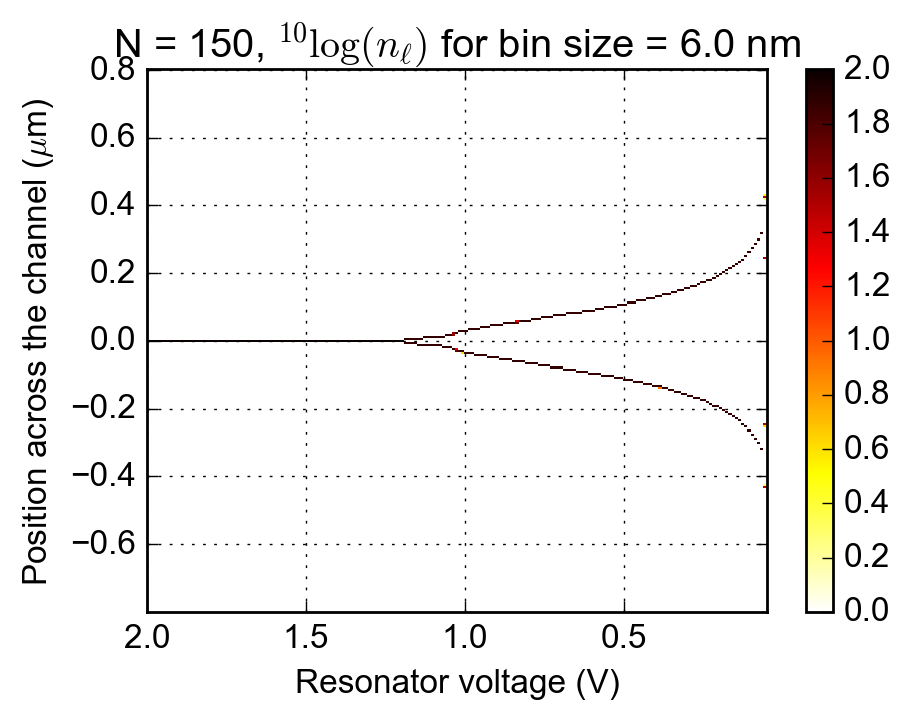

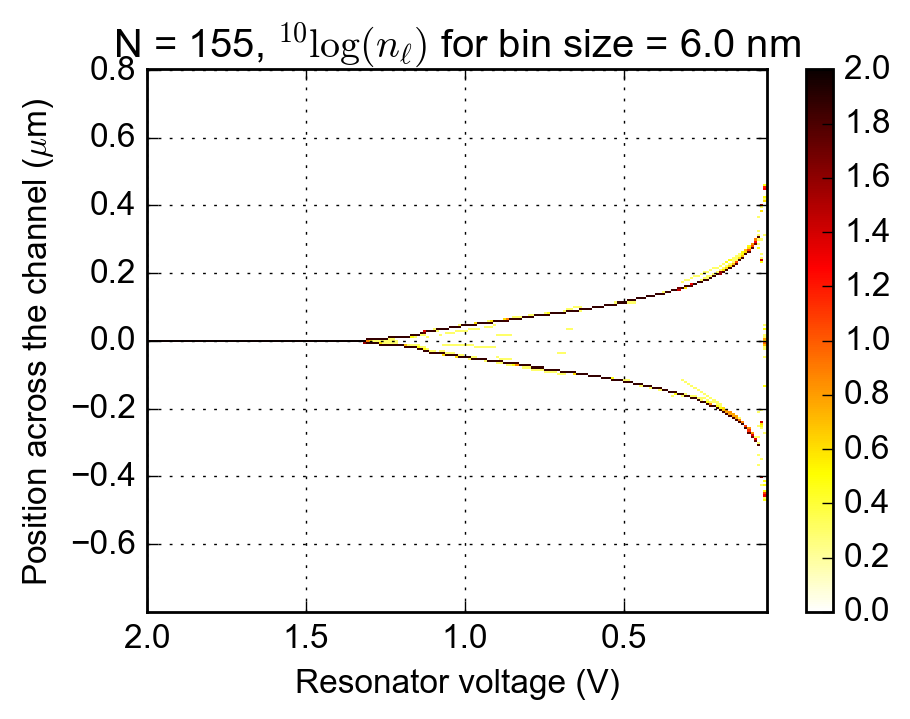

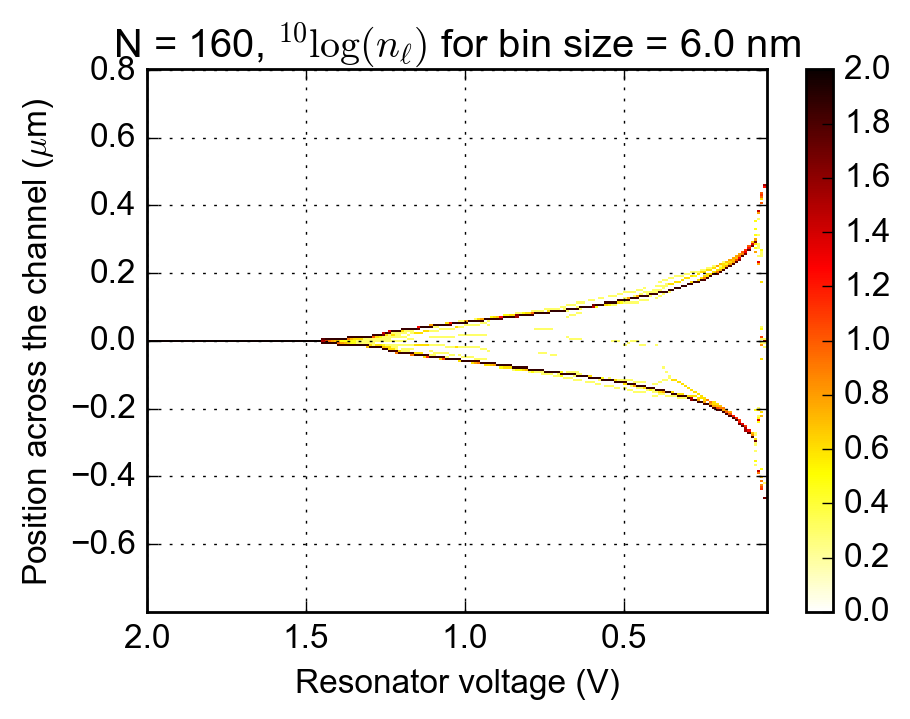

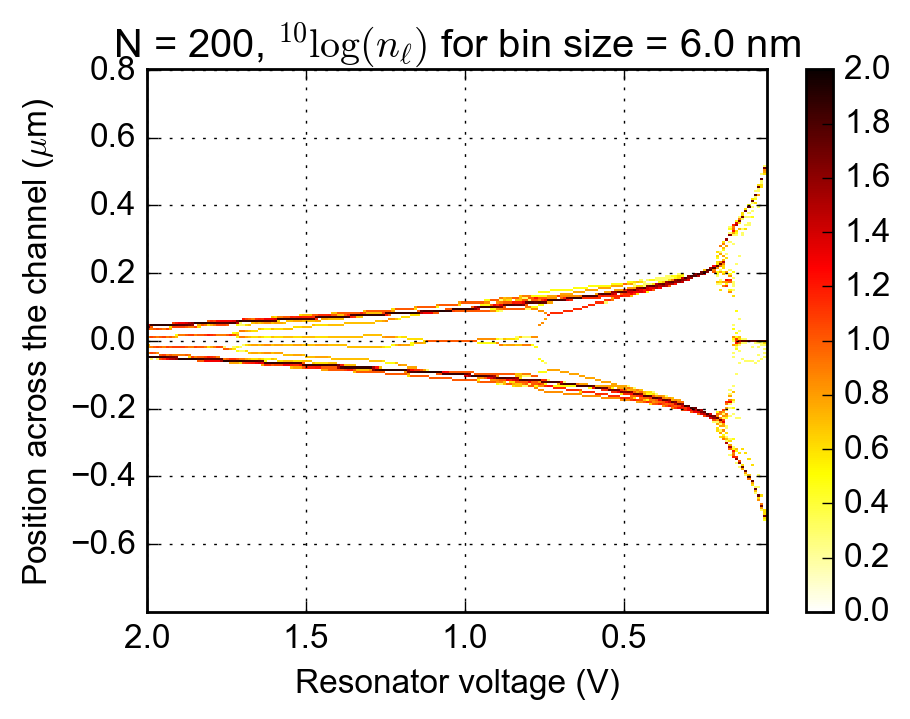

In [80]:
save_path = r"/Volumes/slab/Gerwin/Electron on helium/Electron optimization/Realistic potential/Resonator"
sub_dirs = [r"170118_143444_M018V2_resonator_Vsweep_50_electrons", 
            r"170118_140803_M018V2_resonator_Vsweep_75_electrons",
            r"170118_132418_M018V2_resonator_Vsweep_100_electrons",
            r"170124_101926_M018V2_resonator_Vsweep_125_electrons",
            r"170124_112414_M018V2_resonator_Vsweep_130_electrons",
            r"170124_120809_M018V2_resonator_Vsweep_135_electrons",
            r"170124_131448_M018V2_resonator_Vsweep_140_electrons",
            r"170124_152925_M018V2_resonator_Vsweep_145_electrons",
            r"170124_163706_M018V2_resonator_Vsweep_150_electrons",
            r"170124_175432_M018V2_resonator_Vsweep_155_electrons",
            r"170125_071720_M018V2_resonator_Vsweep_160_electrons",
            r"170118_145233_M018V2_resonator_Vsweep_200_electrons"]

dbin = 0.006E-6
bins = np.arange(-0.80E-6, 0.80E-6+dbin, dbin)
save = False

N_electrons = list()
noof_rows = np.zeros((196, len(sub_dirs)))

for N_axis, sub_dir in enumerate(sub_dirs):
    converged = list()
    energy = list()
    with h5py.File(os.path.join(os.path.join(save_path, sub_dir), "Results.h5"), "r") as f:
        print("Directory: %s" % sub_dir)
        k = 0
        for step in f.keys():
            if "step" in step:
                #print(step)
                electron_ri = f[step + "/electron_final_coordinates"][()]
                xi, yi = anneal.r2xy(electron_ri)
                energy.append(f[step+"/energy"][()])


                valid_solution = f[step + "/solution_converged"][()]
                converged.append(valid_solution)

                if valid_solution:
                    electron_hist, bin_edges = np.histogram(xi, bins=bins)
                else:
                    electron_hist = np.zeros(len(electron_hist))

                if k == 0:
                    electron_histogram = electron_hist
                else:
                    electron_histogram = np.vstack((electron_histogram, electron_hist))

                k += 1
        N_elecs = np.sum(electron_histogram[0,:])
        N_electrons.append(N_elecs)
        N_threshold = 10
        num_peaks = list()
        for V_axis in range(np.shape(electron_histogram)[0]):
            peakind = np.where(electron_histogram[V_axis,:] > N_threshold)[0]
            peakind = np.delete(peakind, np.where(np.diff(peakind) == 1))
            num_peaks.append(len(peakind))
            noof_rows[V_axis, N_axis] = len(peakind)

        Vres = f["Vres"][()]
        xpoints = f["xpoints"][()]
        potential = f["electrostatic_potential"][()]

    print("\tOut of %d simulations, %d did not converge..." % (len(Vres), len(Vres) - np.sum(converged)))

    fig = plt.figure(figsize=(5.,3.5))
    common.configure_axes(12)
    plt.pcolormesh(Vres, bins[:-1]*1E6, np.log10(electron_histogram.T), vmin=0, vmax=2.0, cmap=plt.cm.hot_r)
    plt.colorbar()
    plt.xlim(Vres[0], Vres[-1])
    plt.ylim(np.min(bins)*1E6, np.max(bins)*1E6)
    plt.xlabel("Resonator voltage (V)")
    plt.ylabel("Position across the channel ($\mu$m)")
    plt.title(r"N = %d, $^{10}\log (n_\ell)$ for bin size = %.1f nm"%(N_elecs, dbin*1E9))
    plt.grid()

    if save:
        common.save_figure(fig, os.path.join(save_path, sub_dir))

(0.049999999999998268, 2.0)

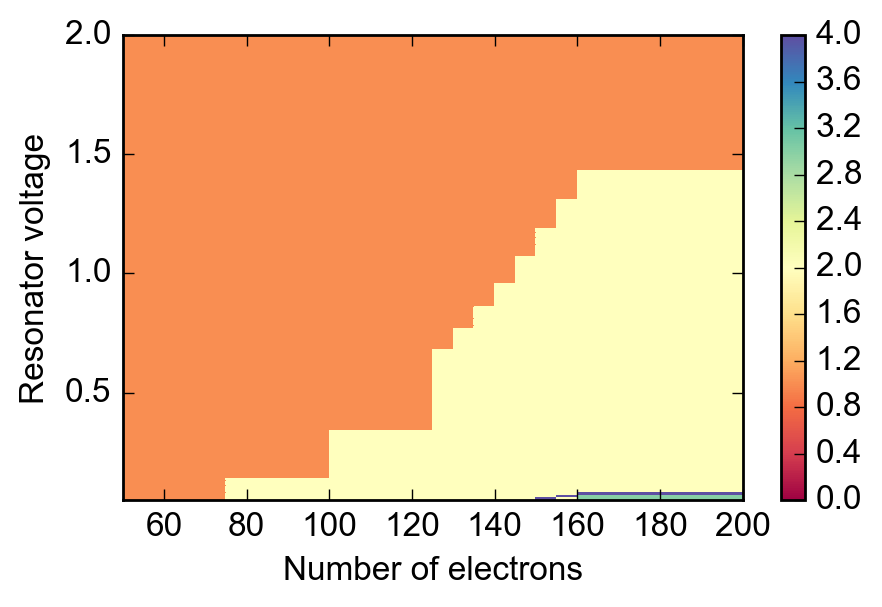

In [81]:
plt.figure(figsize=(5.,3.))
plt.pcolormesh(N_electrons, Vres, noof_rows, cmap=plt.cm.Spectral)
plt.xlabel("Number of electrons")
plt.ylabel("Resonator voltage")
plt.colorbar()
plt.clim(0, 4)
plt.xlim(np.min(N_electrons), np.max(N_electrons))
plt.ylim(np.min(Vres), np.max(Vres))

(1.8999999999999999, 5.0999999999999996)

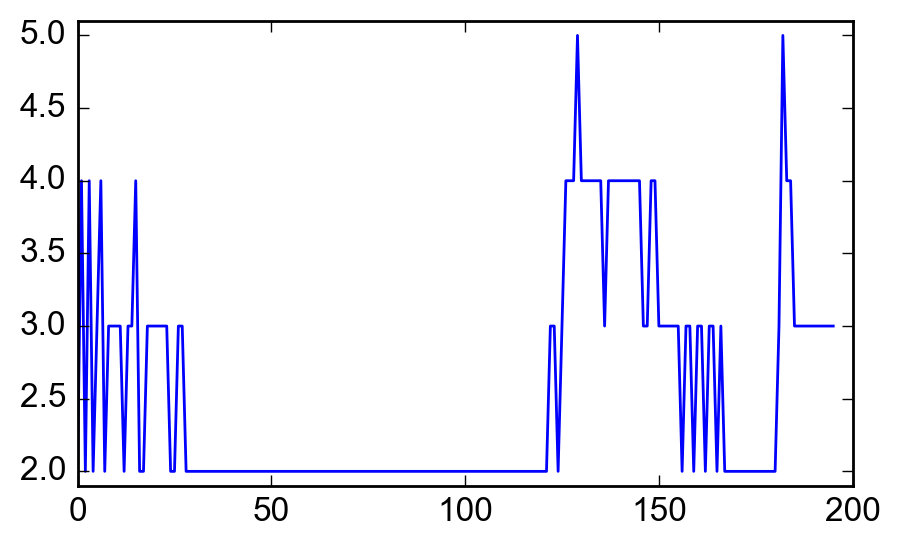

In [60]:
N_electrons = np.sum(electron_histogram[0,:])
N_threshold = 10
num_peaks = list()
for N in range(np.shape(electron_histogram)[0]):
    peakind = np.where(electron_histogram[N,:] > N_threshold)[0]
    peakind = np.delete(peakind, np.where(np.diff(peakind) == 1))
    num_peaks.append(len(peakind))

plt.figure(figsize=(5.,3.))
plt.plot(num_peaks)
ylims = plt.ylim();
plt.ylim(ylims[0]-0.1, ylims[1]+0.1)

In [32]:
PP = anneal.PostProcess()
master_dir = r"/Users/gkoolstra/Desktop/Electron optimization/Realistic potential/Variable density"

def load_from_file(sub_dir):
    electrons_in_trap = list()
    energy = list()
    with h5py.File(os.path.join(os.path.join(master_dir, sub_dir), "Results.h5"), "r") as f:
        for k,step in enumerate(f.keys()):
            electrons_in_trap.append(f[step+"/electrons_in_trap"][()])
            energy.append(f[step+"/energy"][()])

            if k == 0: 
                coefficients = f[step+"/potential_coefficients"][()]
                N_electrons = np.int(len(f[step+"/electron_initial_coordinates"])/2.)
                ns_init = PP.get_electron_density(f[step+"/electron_final_coordinates"][()])
            else:
                coefficients = np.vstack((coefficients, f[step+"/potential_coefficients"][()]))
                
    return coefficients, electrons_in_trap, energy, ns_init

In [73]:
sub_dir = "161101_20_electrons"
coefficients, electrons_in_trap, energy, ns_init = load_from_file(sub_dir)
Vtrap = coefficients[:,1]

The electron density in the figure above is 1.926e+12 m^-2


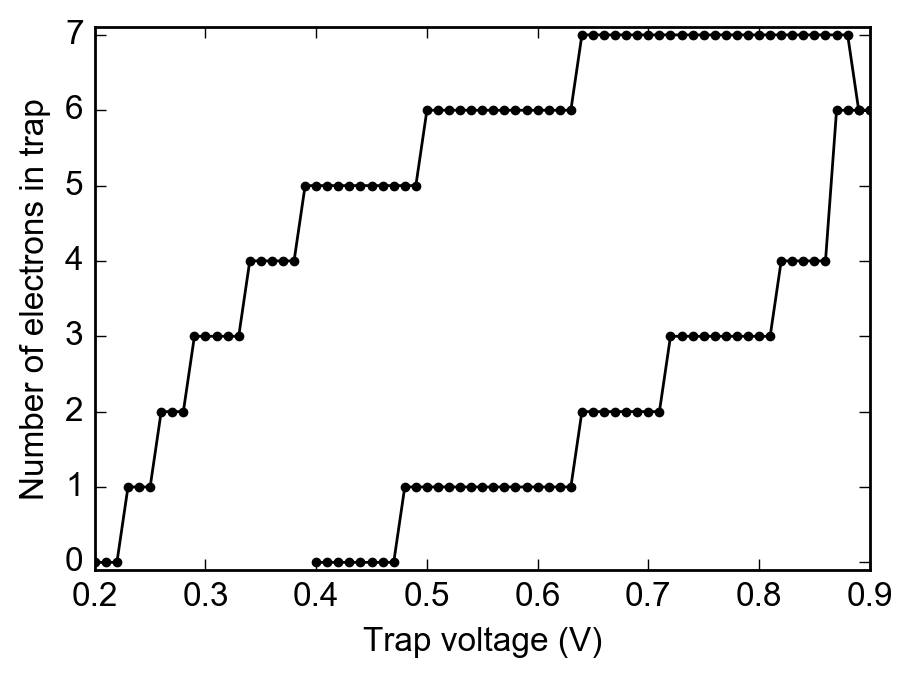

In [74]:
fig = plt.figure(figsize=(5.,3.5))
common.configure_axes(12)
plt.plot(Vtrap, electrons_in_trap, '.-k')
plt.ylabel("Number of electrons in trap")
plt.xlabel("Trap voltage (V)")
plt.ylim(-0.1, np.max(electrons_in_trap)+0.1)
common.save_figure(fig, save_path=os.path.join(master_dir, sub_dir))

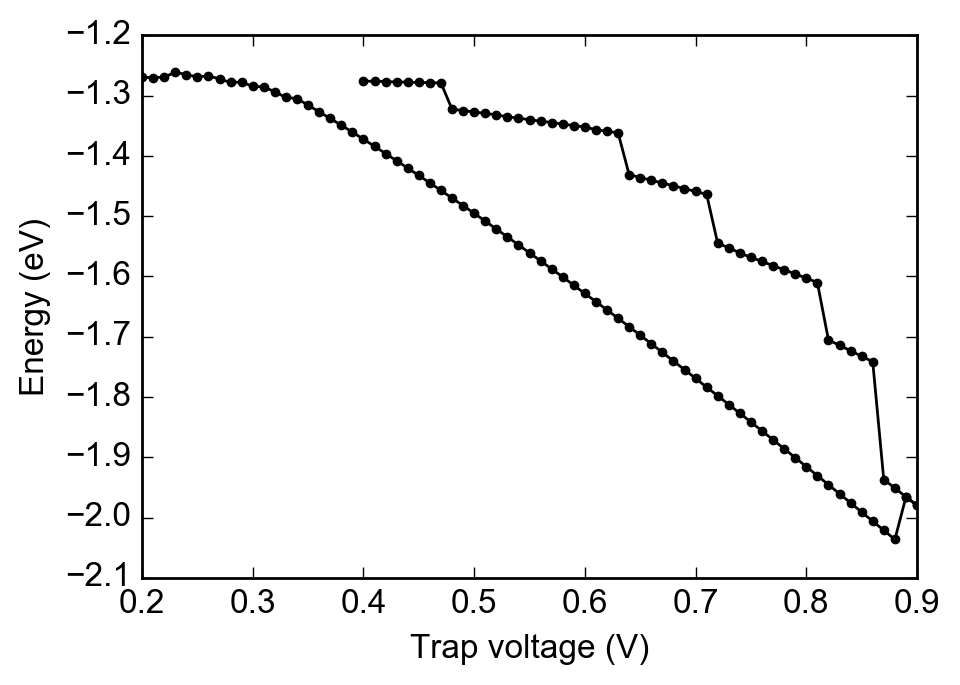

In [75]:
fig = plt.figure(figsize=(5.,3.5))
plt.plot(Vtrap, energy, '.-k')
plt.ylabel("Energy (eV)")
plt.xlabel("Trap voltage (V)")
common.save_figure(fig, save_path=os.path.join(master_dir, sub_dir))

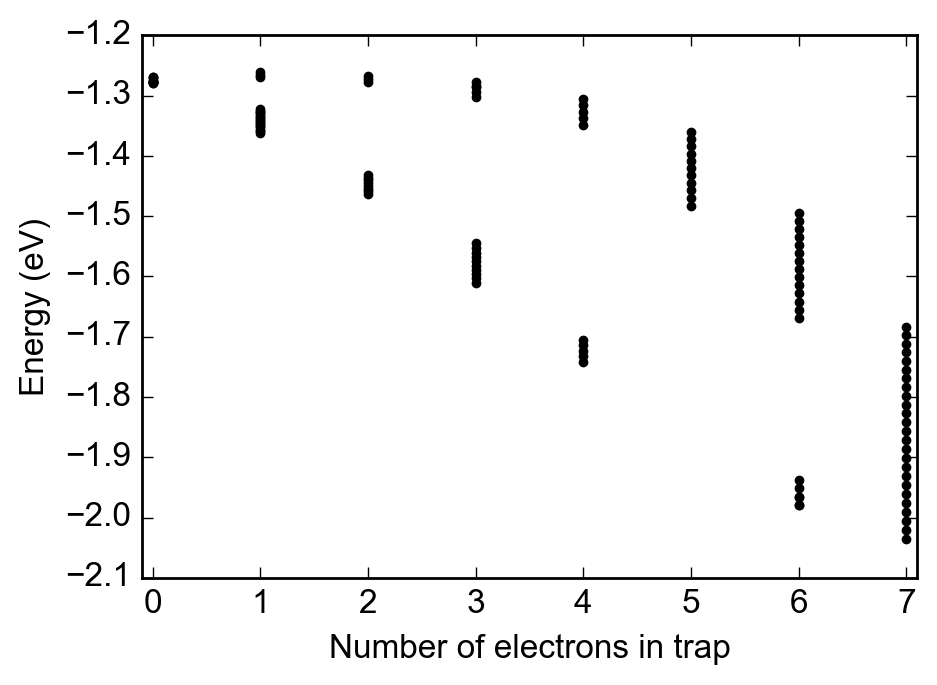

In [76]:
fig = plt.figure(figsize=(5.,3.5))
plt.plot(electrons_in_trap, energy, '.k')
plt.ylabel("Energy (eV)")
plt.xlabel("Number of electrons in trap")
plt.xlim(-0.1, np.max(electrons_in_trap)+0.1)
common.save_figure(fig, save_path=os.path.join(master_dir, sub_dir))